The purpose of this notebook was to establish a base model by which to compare additional models. The initial intention was to construct a classic machine learning model, but such models required more computational resources than was available. Dealing with images through a data generator proved to be computationally efficient and manageable, but data generators could only be used for tensorflow, pytorch or similar neural network models. 

The most appropriate base model to assess the data distribution was a simple logistic regression model. Since traditional classic modelling libraries couldn't be used, a logistic regression model was built through tensorflow using a sequential neural network. This model will serve as the projects based model. Afterwards, more features were added to create a more complex simple sequential network later in this notebook.

The initial steps were to import relevant libraries, import the dataset and scale the data. As mentioned in the EDA notebook, the validation data set was utilized as the test data set. For this reason, a new validation set was created by splitting the training set directly from the data generator. 17.5% of the training set was chosen to be used as the validation dataset simply because it roughly equates to the size of the test data set. 

Within the image data generators, all images were rescaled, randomly rotated, randomly flipped, and shuffled. These manipulations were established to implement as much randomness into the data as possible, while simultaneously maintaining the integrity of the images.  Since these images were round cells without obvious directional polarity, rotatating and flipping the cells should not affect the integrity of the sequential model. These manipulations also have an added benefit of increasing the percieved number of samples by the models. Finally, based on the analysis of colour distribution in the previous EDA report, images were forced to retain their colors before training the model.

In [1]:
#from google.colab import drive
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# Preparing the Data

In [2]:
#drive.mount('/content/drive/')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 180, 
                                   horizontal_flip = True, 
                                   vertical_flip = True, 
                                   validation_split = 0.175)

# Finaly we specify where the images should be loaded from as well as some additional attributes:
train_generator = train_datagen.flow_from_directory('BrainStation/Capstone/capstone_data/training_data', 
                                                    color_mode = 'rgb', 
                                                    class_mode = 'categorical',
                                                    shuffle = True, 
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory('BrainStation/Capstone/capstone_data/training_data', 
                                                         color_mode = 'rgb', 
                                                         class_mode = 'categorical',
                                                         shuffle = True, 
                                                         subset = 'validation')

Found 8796 images belonging to 2 classes.
Found 1865 images belonging to 2 classes.


As mentioned in the EDA notebook, the dataset for this project had a class imbalance, which could negatively impact the performance of the model. In order to combat this issue, a higher weight was assigned to "hem" cells as mentioned in the EDA report. These weights were then passed to the model during training.

In [4]:
7272/3389

2.145765712599587

In [5]:
class_names = validation_generator.class_indices
class_names

{'all': 0, 'hem': 1}

In [6]:
weights = {0: 1,
           1: 2.15}

Sequential models are constructed by adding layers and adjusting the parameters of each individual layer. The model constructed in this notebook was created with three 2-demnsional convlution layers, followed by a flattened layer and 2 dense layers. The convolutional layers recieved the most adjustment in terms of parameter optimization. Regularizers were established on these layers with the sole purpose of reducing overfitting. Two regularizers were available, L1 and L2, with the option to utilize both regularizers in conjuntion for each parameter. Ultimately, L2 was chosen as the sole regularizer since it specifically serves the function of reducing overfitting. Each convolutional layer was also given a dropout function, since doing so also reduces overfitting. All three layers were also given maximum pooling layers. The final output layer of this model was set to a sigmoid activating dense layer with two outputs. This output layer serves to provide a binary classification between two final results, those being cancerous and non-cancerous.

# Logistic Regression Model

In [7]:
base_model = Sequential()

base_model.add(InputLayer(input_shape=(256, 256, 3)))
base_model.add(Flatten())

base_model.add(Dense(2, activation='sigmoid'))

base_model.compile('SGD', 
              loss=tf.losses.CategoricalCrossentropy(), 
              metrics = ['categorical_accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 2)                 393218    
                                                                 
Total params: 393,218
Trainable params: 393,218
Non-trainable params: 0
_________________________________________________________________


2022-07-21 16:45:48.290435: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model_0 = base_model.fit(train_generator, 
                        epochs=10,
                        validation_data = validation_generator, 
                        shuffle=True, 
                        class_weight = weights)

Epoch 1/10
275/275 [==============================] - 175s 635ms/step - loss: 2.7418 - categorical_accuracy: 0.6835 - val_loss: 1.0860 - val_categorical_accuracy: 0.7469
Epoch 2/10
275/275 [==============================] - 191s 694ms/step - loss: 2.6643 - categorical_accuracy: 0.6863 - val_loss: 2.4897 - val_categorical_accuracy: 0.5008
Epoch 3/10
275/275 [==============================] - 199s 725ms/step - loss: 2.5773 - categorical_accuracy: 0.6938 - val_loss: 2.3429 - val_categorical_accuracy: 0.4954
Epoch 4/10
275/275 [==============================] - 213s 775ms/step - loss: 2.4233 - categorical_accuracy: 0.7017 - val_loss: 5.8341 - val_categorical_accuracy: 0.3180
Epoch 5/10
275/275 [==============================] - 220s 799ms/step - loss: 2.6477 - categorical_accuracy: 0.6916 - val_loss: 1.0370 - val_categorical_accuracy: 0.7727
Epoch 6/10
275/275 [==============================] - 222s 807ms/step - loss: 2.4354 - categorical_accuracy: 0.6982 - val_loss: 2.1043 - val_categoric

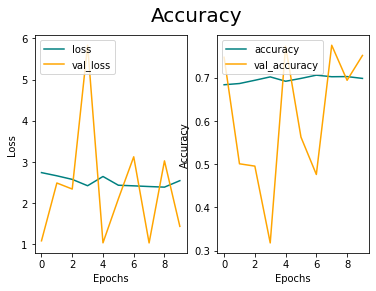

In [9]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(model_0.history['loss'], 
         color = 'teal', 
         label = 'loss')
plt.plot(model_0.history['val_loss'], 
         color = 'orange', 
         label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc = "upper left")
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(model_0.history['categorical_accuracy'], 
         color = 'teal', 
         label = 'accuracy')
plt.plot(model_0.history['val_categorical_accuracy'], 
         color = 'orange', 
         label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

In [10]:
df_test = pd.read_csv("BrainStation/Capstone/capstone_data/test_data/val_data.csv", 
                      dtype = str)
new_labels = []
for row in df_test['labels']:
    if row == '1': new_labels.append('0')
    else: new_labels.append('1')
df_test['new_labels'] = new_labels

df_test

,Patient_ID,new_names,labels,new_labels
0,UID_57_29_1_all.bmp,1.bmp,1,0
1,UID_57_22_2_all.bmp,2.bmp,1,0
2,UID_57_31_3_all.bmp,3.bmp,1,0
3,UID_H49_35_1_hem.bmp,4.bmp,0,1
4,UID_58_6_13_all.bmp,5.bmp,1,0
...,...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1,0
1863,UID_55_24_1_all.bmp,1864.bmp,1,0
1864,UID_H32_20_1_hem.bmp,1865.bmp,0,1
1865,UID_54_30_2_all.bmp,1866.bmp,1,0


In [11]:
# Apply the same rescaling factor as our other generators
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                  directory = 'BrainStation/Capstone/capstone_data/test_data',
                                                  #target_size = (480, 480),
                                                  batch_size = 100,
                                                  x_col = 'new_names',
                                                  y_col = 'new_labels',
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical'
                                                  )

X_test, y_test = test_generator.next()

Found 1867 validated image filenames belonging to 2 classes.


In [13]:
score_0 = base_model.evaluate(X_test, 
                       y_test)

print('Test loss:', score_0[0])
print('Test accuracy:', score_0[1])

4/4 [==============================] - 0s 6ms/step - loss: 2.4048 - categorical_accuracy: 0.7400
Test loss: 2.4048280715942383
Test accuracy: 0.7400000095367432


In [14]:
# Calculate the predictions
predict_probas_0 = base_model.predict(X_test)

# Convert probabilities to label encoding
y_predict_0 = np.argmax(predict_probas_0, axis=1)

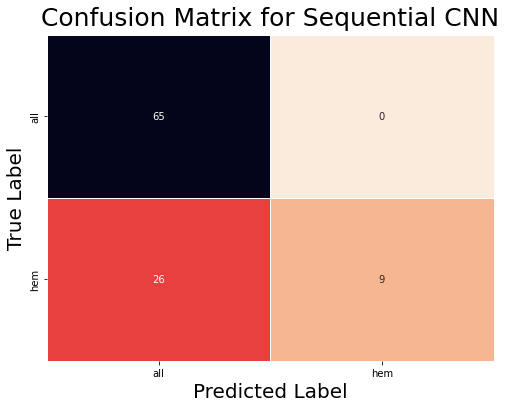

In [15]:
y_test_labels = np.argmax(y_test, axis=1)
conf_mat_0 = confusion_matrix(y_test_labels, y_predict_0)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat_0,
            annot=True,
            cbar=False,
            xticklabels = class_names,
            yticklabels = class_names,
            cmap = "rocket_r",
            linewidths = 1)
plt.title('Confusion Matrix for Logistic Regression', 
          size = 25, 
          y = 1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

# Neural Network Model

In [16]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation = 'relu', 
                 #input_shape = (480, 480, 3)
                 ))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

#model.add(Dense(256, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))

model.compile('SGD', 
              loss=tf.losses.CategoricalCrossentropy(), 
              metrics = ['categorical_accuracy'])
#model.summary()

In [17]:
model_1 = model.fit(train_generator, 
                 epochs = 50, 
                 validation_data = validation_generator, 
                 class_weight = weights)

Epoch 1/50
 57/275 [=====>........................] - ETA: 4:32 - loss: 0.8040 - categorical_accuracy: 0.7670

KeyboardInterrupt: 

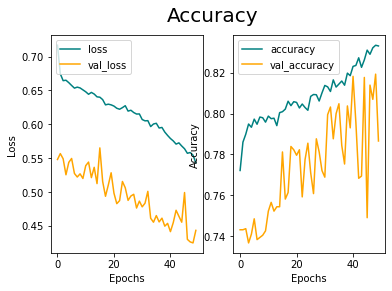

In [ ]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(model_1.history['loss'], 
         color = 'teal', 
         label = 'loss')
plt.plot(model_1.history['val_loss'], 
         color = 'orange', 
         label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc = "upper left")
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(model_1.history['categorical_accuracy'], 
         color = 'teal', 
         label = 'accuracy')
plt.plot(model_1.history['val_categorical_accuracy'], 
         color = 'orange', 
         label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc = "upper left")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

The final phase of analysis was to assess the models performance on the testing data. Just as for the training and validation data, the testing data was imported via an image generator. However, in the original dataset, the validation data was was labelled differently than the training set. This issue was discussed further in the EDA notebook. For this reason, a different methodology was used to import the data. The validation images were imported and labelled in accordance to the CSV file (and subsequent extracted dataframe) that was provided with the original data. The same parameter optimizations that were utilized for the training and validation generators were utilized for the test generator as well. 

In [ ]:
# Evaluate the model's performance on the test data
score_1 = model.evaluate(X_test, 
                       y_test)

print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

4/4 [==============================] - 1s 176ms/step - loss: 0.6889 - categorical_accuracy: 0.7200
Test loss: 0.6888883113861084
Test accuracy: 0.7200000286102295


In [ ]:
# Calculate the predictions
predict_probas_1 = model.predict(X_test)

# Convert probabilities to label encoding
y_predict_1 = np.argmax(predict_probas_1, axis=1)

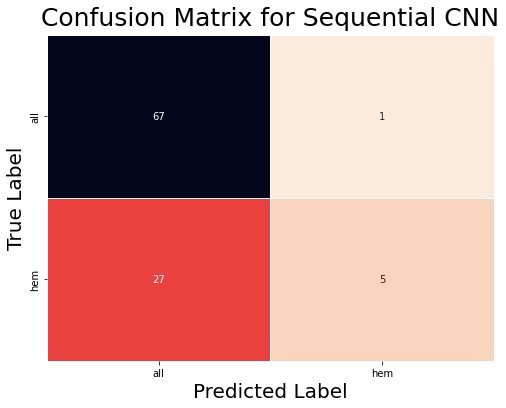

In [ ]:
conf_mat_1 = confusion_matrix(y_test_labels, y_predict_1)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat_1,
            annot=True,
            cbar=False,
            xticklabels = class_names,
            yticklabels = class_names,
            cmap = "rocket_r",
            linewidths = 1)
plt.title('Confusion Matrix for Sequential CNN', 
          size = 25, 
          y = 1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()